# What drives the price of a car?

![](images/kurt.jpeg)

### OVERVIEW

This notebook analyzes a Kaggle used-cars dataset (`vehicles.csv`) to understand **which factors drive used car prices** and to build **regression models** that can help a used car dealership fine-tune its inventory strategy.  The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  The result of this analysis  should provide clear recommendations to the client, a used car dealership. as to what consumers value in a used car.

Key modeling techniques to be used are different families of the following: 
  - **Baseline Linear Regression**
  - **Regularized Linear Models** (Ridge, Lasso)
  - **Polynomial Regression (degree 2) on numeric features**
- Explore **PCA**, **DBSCAN** (for anomaly detection / segmentation), and **loss computation & optimization**

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 25%/>
</center>


The workflow follows **CRISP-DM framework**, a standard process in industry for data projects.  The key phases are as follows:
1. Business Understanding  
2. Data Understanding  
3. Data Preparation  
4. Modeling  
5. Evaluation  
6. Deployment & Reporting 

### 1. Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

**Problem Statement**  
A used car dealership wants to know which characteristics (`car_age`, `odometer`, `manufacturer`, `model`, `fuel`, `condition`, etc.) most strongly influence the **price** of a used car. They want to:
- Price incoming vehicles more accurately  
- Prioritize buying inventory that tends to hold value  
- Identify outliers or suspiciously priced vehicles  

**Data Science / ML Problem Framing and Tasks**  
This will be framed as a **supervised regression problem**:
- **Target variable**: `price` (continuous numeric variable)  
- **Features**: car attributes such as `car_age`, `odometer`, `manufacturer`, `model`, `fuel`, `condition`, etc.  
- **Goal**:  
  - Build regression models that predict `price` for a given set of car attributes to understand **what drives price**.  

In [68]:
#Import Python libraries.  We can adjest the list (add or remove) as appropriate

import numpy as np
import pandas as pd

# ploting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Display options
pd.set_option('display.max_columns', 50)
sns.set(style="whitegrid")  


# Modeling and preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Dimensionality reduction
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import DBSCAN

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


### 2. Data Understanding

After considering the business understanding, we want to get familiar with our data.  Following high level steps that we would take to get to know the dataset and identify any quality issues within.  

**2.1 Steps to undestand the data starting with data load**
- Load the dato into a DataFrame
- Perform EDA to determine the usefullness of data, need to for eleminating null value element, conversion of catagorical data into nueric value
- Perform the data prep based on the finding of EDA

In [69]:
#load the data into a dataframe
df_vehicles = pd.read_csv('data/vehicles.csv')

print("Shape of the dataset (rows, columns):", df_vehicles.shape)
print('')
print (df_vehicles.info())
print('')
df_vehicles.head()

Shape of the dataset (rows, columns): (426880, 18)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


**2.2 Exploratory Data Analysis (EDA)**
This is the diagnostic phase of the data to be used for modeling and to ensure that the models are built based on relevant data.  FOllowing are some of the purposes of EDA:
- Identify and correct missing and inconsistent data
- Identify patterns, trends and statistical properties of the data
- Inform Feature Engineering
- Narrow down the model selection

Top 15 columns by number of missing values:


size            306361
cylinders       177678
condition       174104
VIN             161042
drive           130567
paint_color     130203
type             92858
manufacturer     17646
title_status      8242
model             5277
odometer          4400
fuel              3013
transmission      2556
year              1205
region               0
dtype: int64


Descriptive statistics for numeric columns:


,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


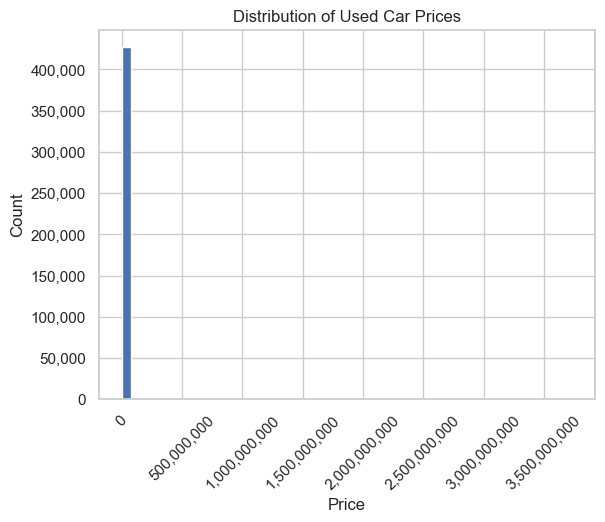

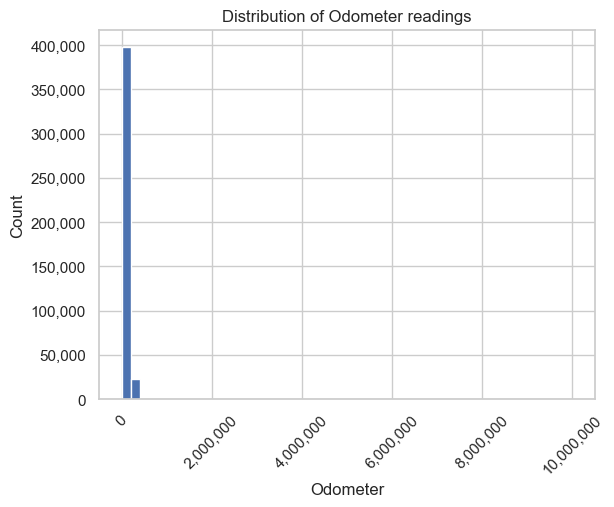


Price quantiles:
0.01        0.0
0.05        0.0
0.50    13950.0
0.95    44500.0
0.99    66995.0
Name: price, dtype: float64

Odometer quantiles:
0.01         2.0
0.05      6318.0
0.50     85548.0
0.95    204000.0
0.99    280000.0
Name: odometer, dtype: float64


In [70]:
formatter = FuncFormatter(lambda x, pos: f"{x:,.0f}")

# Missing values by column
missing = df_vehicles.isna().sum().sort_values(ascending=False)
print("Top 15 columns by number of missing values:")
display(missing.head(15))

# Stats for numeric columns
print("\nDescriptive statistics for numeric columns:")
display(df_vehicles.describe())

# Nature of Price data
plt.figure()
df_vehicles['price'].hist(bins=50)
#df_vehicles.boxplot(column=['price'])
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Distribution of Used Car Prices")
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain')
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_formatter(formatter)
plt.show()

# Nature of Odometer data
plt.figure()
df_vehicles['odometer'].hist(bins=50)
#df_vehicles.boxplot(column=['price'])
plt.xlabel("Odometer")
plt.ylabel("Count")
plt.title("Distribution of Odometer readings")
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain')
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_formatter(formatter)
plt.show()

# Basic quantiles of price to understand skew / outliers
print("\nPrice quantiles:")
print(df_vehicles['price'].quantile([0.01, 0.05, 0.5, 0.95, 0.99]))

# Basic quantiles of price to understand skew / outliers
print("\nOdometer quantiles:")
print(df_vehicles['odometer'].quantile([0.01, 0.05, 0.5, 0.95, 0.99]))

**2.3 Explore Key Categorical and Numeric Features**

Look at common categories and basic relationships with price.

Top manufacturers by count:


manufacturer
ford         70985
chevrolet    55064
toyota       34202
honda        21269
nissan       19067
jeep         19014
ram          18342
gmc          16785
bmw          14699
dodge        13707
Name: count, dtype: int64

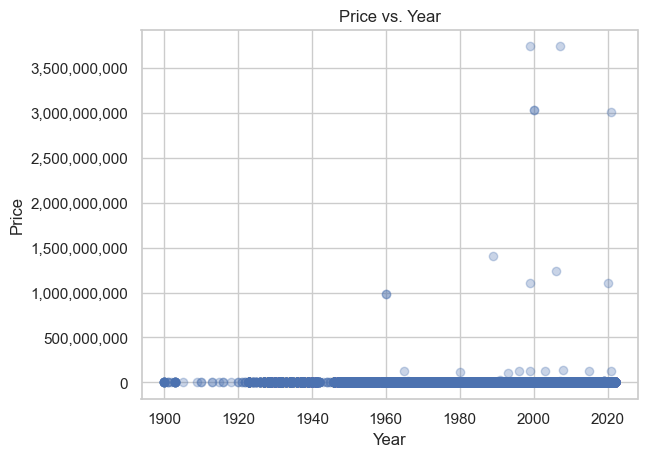

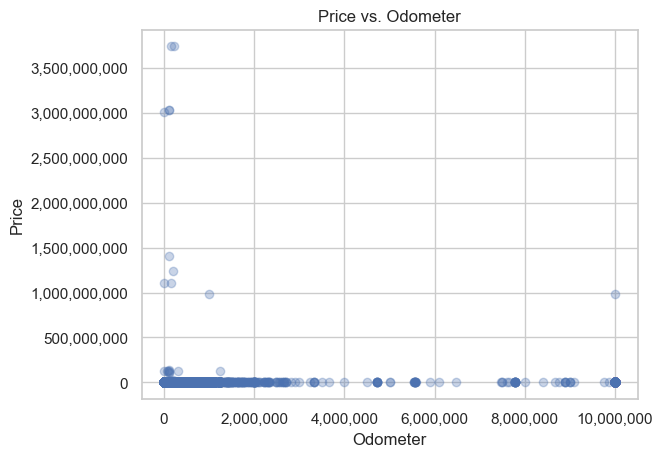

In [71]:

formatter = FuncFormatter(lambda x, pos: f"{x:,.0f}")

# Top manufacturers by count
print("Top manufacturers by count:")
display(df_vehicles['manufacturer'].value_counts().head(10))

# Year and Price (scatter plot)
plt.figure()
plt.scatter(df_vehicles['year'], df_vehicles['price'], alpha=0.3)
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("Price vs. Year")
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

# Odometer and Price (scatter plot)
plt.figure()
#plt.scatter(sample['odometer'], sample['price'], alpha=0.3)
plt.scatter(df_vehicles['odometer'], df_vehicles['price'], alpha=0.3)
plt.xlabel("Odometer")
plt.ylabel("Price")
plt.title("Price vs. Odometer")
plt.ticklabel_format(style='plain')
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_formatter(formatter)
plt.show()

**2.4 Findings and Data Proprocessing Needs**

Based on the initial exploration, immediate steps will be:

**Target Cleaning**
   - Remove rows with missing or zero / negative `price` values.
   - Remove extreme outliers (very low or very high prices and odometer reading that are unrealistic).
   - Remove rows with missing year values.

**Feature Selection / Dropping**
   - Drop clearly non-predictive identifiers such as `id`, `VIN` (if mostly unique or heavily missing).
   - Use **`car_age` instead of raw `year`** to avoid redundant, highly collinear information.

**Handling Missing Values**
   - For numeric features (e.g. `odometer`, `car_age`): impute with median or use domain rules.
   - For categorical features (e.g. `manufacturer`, `condition`, `fuel`): impute with `"Unknown"` or a new category.

**Feature Engineering**
   - `car_age` = reference_year − `year`  
   - `log_price` to reduce skew in price distribution  
   - `price_per_mile` = `price` / `odometer` (captures value relative to mileage).

**Encoding & Scaling**
   - Use `OneHotEncoder` for categorical variables.  
   - Use `StandardScaler` for numeric variables when needed (e.g. for PCA, DBSCAN, regularized models, polynomial regression).

### 3. Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 
- Clean the target variable.
- Remove or fix obvious outliers.
- Handle missing values.
- Create engineered features.
- Define feature lists and build preprocessing pipelines.

In [72]:
# 3.1 Data Cleaning

print("Shape without any cleaning (original data):", df_vehicles.shape)

# Remove rows with missing price
df_vehicles_clean = df_vehicles.dropna(subset=['price']).copy()

# Remove non-positive prices (<= 0)
df_vehicles_clean = df_vehicles_clean[df_vehicles_clean['price'] > 0].copy()

print("Shape after removing missing/invalid prices:", df_vehicles_clean.shape)

#Remove Price outliers outside of 1 and 99 percentile.
lower_p, upper_p = df_vehicles_clean['price'].quantile([0.01, 0.99])
df_vehicles_clean = df_vehicles_clean[(df_vehicles_clean['price'] >= lower_p) & (df_vehicles_clean['price'] <= upper_p)].copy()

print("Shape after trimming extreme price outliers:", df_vehicles_clean.shape)

#Remove rows with missing year
df_vehicles_clean = df_vehicles_clean[df_vehicles_clean['year'] > 0].copy()

print("Shape after trimming missing year:", df_vehicles_clean.shape)

#Remove Price outliers outside of 1 and 99 percentile.
lower_o, upper_o = df_vehicles_clean['odometer'].quantile([0.01, 0.99])
df_vehicles_clean = df_vehicles_clean[(df_vehicles_clean['odometer'] >= lower_o) & (df_vehicles_clean['odometer'] <= upper_o)].copy()

print("Shape after trimming extreme odometer outliers:", df_vehicles_clean.shape)

Shape without any cleaning (original data): (426880, 18)
Shape after removing missing/invalid prices: (393985, 18)
Shape after trimming extreme price outliers: (386121, 18)
Shape after trimming missing year: (385053, 18)
Shape after trimming extreme odometer outliers: (375273, 18)


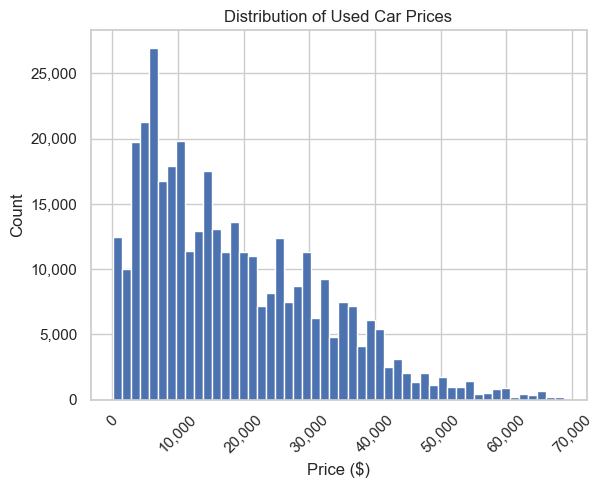

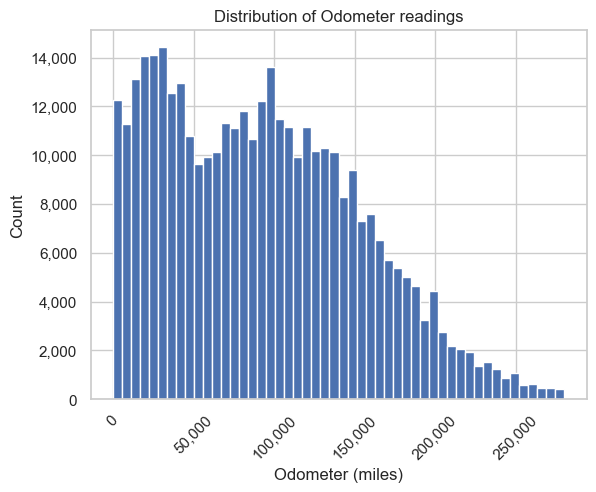

In [73]:
#3.1.1 Redraw the Histrogram based on clean data
formatter = FuncFormatter(lambda x, pos: f"{x:,.0f}")

# Price distribution after cleanin
plt.figure()
df_vehicles_clean['price'].hist(bins=50)
#df_vehicles.boxplot(column=['price'])
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.title("Distribution of Used Car Prices")
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain')
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_formatter(formatter)
plt.show()

# Price distribution after cleanin
plt.figure()
df_vehicles_clean['odometer'].hist(bins=50)
#df_vehicles.boxplot(column=['price'])
plt.xlabel("Odometer (miles)")
plt.ylabel("Count")
plt.title("Distribution of Odometer readings")
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain')
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_formatter(formatter)
plt.show()

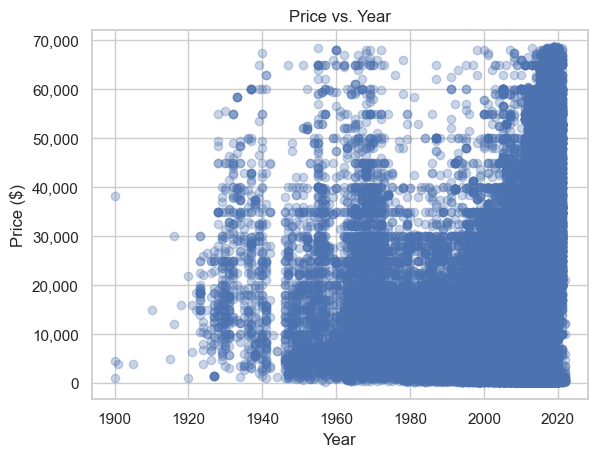

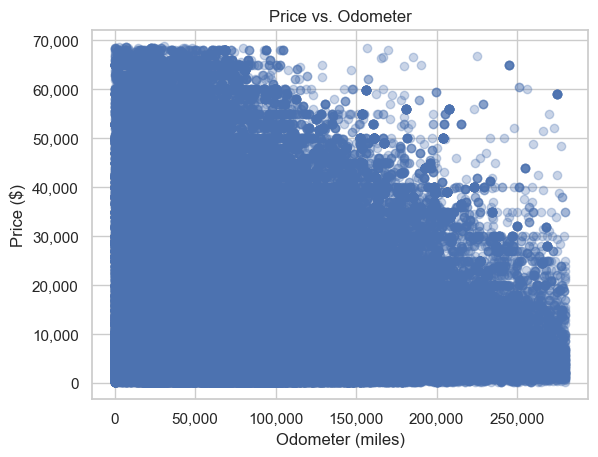

In [74]:
#3.1.2 Redraw the scatter plots (price vs year) and (price vs odomtere)

formatter = FuncFormatter(lambda x, pos: f"{x:,.0f}")

# Year and Price (scatter plot)
plt.figure()
plt.scatter(df_vehicles_clean['year'], df_vehicles_clean['price'], alpha=0.3)
plt.xlabel("Year")
plt.ylabel("Price ($)")
plt.title("Price vs. Year")
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

# Odometer and Price (scatter plot)
plt.figure()
#plt.scatter(sample['odometer'], sample['price'], alpha=0.3)
plt.scatter(df_vehicles_clean['odometer'], df_vehicles_clean['price'], alpha=0.3)
plt.xlabel("Odometer (miles)")
plt.ylabel("Price ($)")
plt.title("Price vs. Odometer")
plt.ticklabel_format(style='plain')
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_formatter(formatter)
plt.show()

In [75]:
# 3.2 Feature Engineering

# car_age: approximate age of the car
# log_price: log-transform of price for potentially better-behaved residuals
# price_per_mile: value relative to mileage (used as an extra signal)

#reference_year: assume the data is as of a year after the maximum 'year' in the data set
reference_year = df_vehicles_clean['year'].max() + 1

# Create car_age where year is not missing
df_vehicles_clean['car_age'] = reference_year - df_vehicles_clean['year']

# Log-transform price (add small constant to avoid log(0))
df_vehicles_clean['log_price'] = np.log1p(df_vehicles_clean['price'])

# Example: price per mile (use where odometer > 0)
df_vehicles_clean['price_per_mile'] = np.where(
    (df_vehicles_clean['odometer'] > 0) & (~df_vehicles_clean['odometer'].isna()),
    df_vehicles_clean['price'] / df_vehicles_clean['odometer'],
    np.nan
)

df_vehicles_clean[['price', 'log_price', 'car_age', 'price_per_mile']].head()


,price,log_price,car_age,price_per_mile
27,33590,10.422013,9.0,0.579908
28,22590,10.025307,13.0,0.317146
29,39590,10.586357,3.0,2.066284
30,30990,10.341452,6.0,0.753575
31,15000,9.615872,10.0,0.117188


In [76]:
# 3.3 Define Features and Target

target = 'price'  

numeric_features = ['odometer', 'car_age']
#categorical_features = ['region', 'manufacturer', 'model', 'condition',
 #                       'cylinders', 'fuel', 'title_status', 'transmission',
  #                      'drive', 'size', 'type', 'paint_color', 'state']

categorical_features = [ 'manufacturer', 'condition', 'size']

X = df_vehicles_clean[numeric_features + categorical_features].copy()
y = df_vehicles_clean[target].copy()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)
print("X shape:", X.shape)
print("y shape:", y.shape)

Numeric features: ['odometer', 'car_age']
Categorical features: ['manufacturer', 'condition', 'size']
X shape: (375273, 5)
y shape: (375273,)


In [77]:
# 3.4 Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (300218, 5)
Test shape: (75055, 5)


In [78]:
# 3.5 Preprocessing Pipelines

# Numeric pipeline: impute missing values, then scale
numeric_transformer = Pipeline(
    steps=[ ("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# Categorical pipeline: impute missing, then one-hot encode
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

# ColumnTransformer to apply the right preprocessing to each column subset
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features), ("cat", categorical_transformer, categorical_features)]
)

print("Preprocessor defined.")

Preprocessor defined.


### 4. Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

1. Baseline **Linear Regression (Simple/Multiple)**  
2. Regularized models (**Ridge**, **Lasso**)  
3. **Polynomial Regression (degree 2)** on numeric features (combined with categorical one-hot encoding)  

Evaluate models primarily using:
- **RMSE** (Root Mean Squared Error)  
- **MAE** (Mean Absolute Error)  
- **R²** (Coefficient of Determination)  

In [79]:
# 4.1 Baseline Multiple Linear Regression with Cross-Validation

# Build pipeline 
linreg_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LinearRegression())
    ]
)

# RMSE and MAE for cross_val_score
neg_rmse_scores = cross_val_score(
    linreg_model, X_train, y_train,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1
)
neg_mae_scores = cross_val_score(
    linreg_model, X_train, y_train,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1
)

print("Baseline Linear Regression")
print("---------------------------------")
print("CV RMSE:", -neg_rmse_scores.mean(), "+/-", neg_rmse_scores.std())
print("CV MAE :", -neg_mae_scores.mean(), "+/-", neg_mae_scores.std())

Baseline Linear Regression
---------------------------------
CV RMSE: 9884.177416244343 +/- 24.679646365638877
CV MAE : 7240.4102937270745 +/- 10.970855672914942


In [80]:
# 4.2 Regularized Linear Models: Ridge, Lasso, ElasticNet with Grid Search

# Define parameter grids for each model
ridge_params = {"model__alpha": [0.1, 1.0, 10.0]}
#lasso_params = {"model__alpha": [0.0001, 0.001, 0.01, 0.1]}
#elastic_params = {
   # "model__alpha": [0.0001, 0.001, 0.01],
   # "model__l1_ratio": [0.2, 0.5, 0.8]
#}

def run_grid_search(base_model, param_grid, model_name):
    """Utility function to run GridSearchCV on a given base model."""
    pipe = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("model", base_model)
        ]
    )
    grid = GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    best_rmse = -grid.best_score_
    print(f"\n{model_name} - Best CV RMSE: {best_rmse:.2f}")
    print("Best parameters:", grid.best_params_)
    return grid

ridge_grid = run_grid_search(Ridge(), ridge_params, "Ridge")
#lasso_grid = run_grid_search(Lasso(max_iter=1000), lasso_params, "Lasso")
#Lasso_grid was commented out due to performance issue

Fitting 3 folds for each of 3 candidates, totalling 9 fits

Ridge - Best CV RMSE: 9884.65
Best parameters: {'model__alpha': 10.0}


In [81]:
# 4.3 Polynomial Regression (Degree 2 on Numeric Features)

# polynomial regression limited to numeric features to degree 2,
# one-hot encoded for categorical features

numeric_transformer_poly = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2, include_bias=False))
    ]
)

preprocessor_poly = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_poly, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

poly2_linreg_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor_poly),
        ("model", LinearRegression())
    ]
)

neg_rmse_poly = cross_val_score(
    poly2_linreg_model, X_train, y_train,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1
)
neg_mae_poly = cross_val_score(
    poly2_linreg_model, X_train, y_train,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1
)

print("Polynomial Regression (Degree 2, Numeric Features Only)")
print("-------------------------------------------------------")
print("CV RMSE:", -neg_rmse_poly.mean(), "+/-", neg_rmse_poly.std())
print("CV MAE :", -neg_mae_poly.mean(), "+/-", neg_mae_poly.std())

Polynomial Regression (Degree 2, Numeric Features Only)
-------------------------------------------------------
CV RMSE: 9363.220665949697 +/- 23.93365886879542
CV MAE : 6683.638284786117 +/- 12.678986252069532


In [82]:
# 4.4 Compare Models on Validation Scores (Based on Best RMSE)

results = {
    "LinearRegression_CV_RMSE": None,  # We'll reuse CV from above
    "Ridge_Best_CV_RMSE": -ridge_grid.best_score_,
    "Poly2_LinearRegression_CV_RMSE": -neg_rmse_poly.mean(),
}

# Recompute baseline Linear Regression CV RMSE for consistency
neg_rmse_lin = cross_val_score(
    linreg_model, X_train, y_train,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1
)
results["LinearRegression_CV_RMSE"] = -neg_rmse_lin.mean()

print("Model comparison (lower RMSE is better):")
for k, v in results.items():
    print(f"{k}: {v:.2f}")


Model comparison (lower RMSE is better):
LinearRegression_CV_RMSE: 9884.18
Ridge_Best_CV_RMSE: 9884.65
Poly2_LinearRegression_CV_RMSE: 9363.22


### 4.5 PCA for Dimensionality Reduction

Explained variance ratio by component:
[0.6649148 0.3350852]


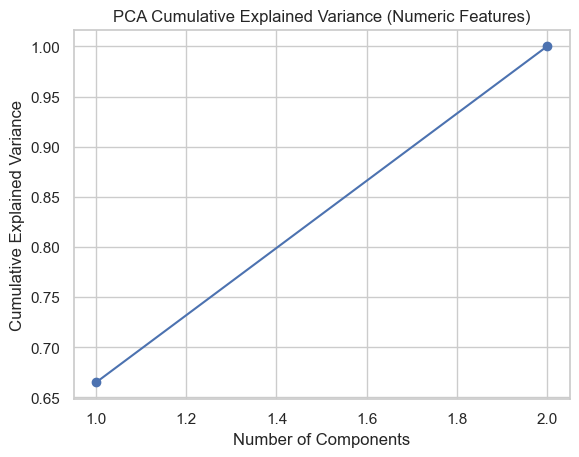

In [83]:
# 4.5.1 PCA on Numeric Features Only (Exploratory)

# Extract numeric subset from cleaned data
numeric_df = df_vehicles_clean[numeric_features].copy()

# Impute and scale numeric features
num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()

numeric_array = num_imputer.fit_transform(numeric_df)
numeric_scaled = num_scaler.fit_transform(numeric_array)

# Fit PCA
pca = PCA(n_components=min(len(numeric_features), 6))  # up to 6 components for exploration
pca.fit(numeric_scaled)

print("Explained variance ratio by component:")
print(pca.explained_variance_ratio_)

# Scree plot
plt.figure()
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Cumulative Explained Variance (Numeric Features)")
plt.grid(True)
plt.show()


In [84]:

# 4.5.2 : PCA Models

print("Running PCA models...")


# PCA Transformer for numeric features 

def make_pca_preprocessor(n_components):
    return ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
                ("pca", PCA(n_components=n_components))
            ]), numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder="drop"
    )

# Determine safe n_components
# Count numeric features
n_num = len(numeric_features)

# Reasonable PCA limit
safe_n = min(5, n_num)  # At most 5 components, but no more than numeric features

print(f"Using n_components={safe_n} for PCA.")


# PCA on Linear Regression
pca_linreg = Pipeline([
    ("preprocessor", make_pca_preprocessor(safe_n)),
    ("model", LinearRegression())
])

pca_linreg_scores = cross_val_score(
    pca_linreg, X_train, y_train,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)


# PCA on Polynomial Regression (Degree 2)
pca_poly_preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("poly", PolynomialFeatures(degree=2, include_bias=False)),
            ("pca", PCA(n_components=safe_n))
        ]), numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

pca_poly_model = Pipeline([
    ("preprocessor", pca_poly_preprocessor),
    ("model", LinearRegression())
])

pca_poly_scores = cross_val_score(
    pca_poly_model, X_train, y_train,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)


# PCA on Ridge Regression
pca_ridge = Pipeline([
    ("preprocessor", make_pca_preprocessor(safe_n)),
    ("model", Ridge(alpha=1.0))
])

pca_ridge_scores = cross_val_score(
    pca_ridge, X_train, y_train,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)



print("\n=== PCA Model Summary (RMSE) ===")
print(f"PCA + Linear Regression      : {-pca_linreg_scores.mean():.2f}")
print(f"PCA + Poly Regression (deg2) : {-pca_poly_scores.mean():.2f}")
print(f"PCA + Ridge                  : {-pca_ridge_scores.mean():.2f}")


Running PCA models...
Using n_components=2 for PCA.

=== PCA Model Summary (RMSE) ===
PCA + Linear Regression      : 9885.01
PCA + Poly Regression (deg2) : 11769.69
PCA + Ridge                  : 9883.88


### 4.6 DBSCAN for Anomaly Detection / Segmentation

#### SKIP
The code was taking too long and was hanging up due to the limited resource of the local laptop

### 4.7 Compute and Optimize Loss 

In [85]:
# 4.7.1 Manual Loss Computation for a Fitted Model (Baseline Linear Regression)

# Fit baseline linear regression on the training data
linreg_model.fit(X_train, y_train)

# Predict on test data
y_pred_test = linreg_model.predict(X_test)

# Manual computation of MSE, RMSE, MAE
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("Test Set Performance (Baseline Linear Regression)")
print("-------------------------------------------------")
print(f"MSE : {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R^2 : {r2:.3f}")

Test Set Performance (Baseline Linear Regression)
-------------------------------------------------
MSE : 95474348.52
RMSE: 9771.10
MAE : 7172.62
R^2 : 0.460


## 5. Final Model Selection, Evaluation, and Interpretation

In [86]:
# 5.1 Choose the Best Model Based on CV RMSE

best_model_name = min(results, key=results.get)
print("Best model based on CV RMSE:", best_model_name)

# Map the name to the corresponding fitted estimator
if "Ridge" in best_model_name:
    final_model = ridge_grid.best_estimator_
elif "Poly2" in best_model_name:
    final_model = poly2_linreg_model
else:
    # fall back to baseline linear regression pipeline
    final_model = linreg_model

# Fit final model to training data
final_model.fit(X_train, y_train)

# predict
y_pred_final = final_model.predict(X_test)

mse_final = mean_squared_error(y_test, y_pred_final)
rmse_final = np.sqrt(mse_final)
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print("Final Model Test Performance")
print("----------------------------")
print("Model:", best_model_name)
print(f"RMSE: {rmse_final:.2f}")
print(f"MAE : {mae_final:.2f}")
print(f"R^2 : {r2_final:.3f}")

Best model based on CV RMSE: Poly2_LinearRegression_CV_RMSE
Final Model Test Performance
----------------------------
Model: Poly2_LinearRegression_CV_RMSE
RMSE: 9267.10
MAE : 6613.26
R^2 : 0.514


In [87]:
# 5.2 Interpret Coefficients / Feature Effects 

# Extract feature names and coefficients.

# Identify preprocessor and linear step
preprocess_step = final_model.named_steps['preprocessor']
linear_step = final_model.named_steps['model']

# For numeric part, if polynomial features are present, get names from PolynomialFeatures
try:
    num_pipeline = preprocess_step.named_transformers_['num']
    if 'poly' in num_pipeline.named_steps:
        poly = num_pipeline.named_steps['poly']
        num_features_out = poly.get_feature_names_out(numeric_features)
    elif 'scaler' in num_pipeline.named_steps:
        num_features_out = num_pipeline.named_steps['scaler'].get_feature_names_out(numeric_features)
    else:
        num_features_out = np.array(numeric_features)
except Exception as e:
    print("Warning: could not extract numeric feature names precisely:", e)
    num_features_out = np.array(numeric_features)

# Categorical one-hot feature names
try:
    cat_ohe = preprocess_step.named_transformers_['cat'].named_steps['onehot']
    cat_features_out = cat_ohe.get_feature_names_out(categorical_features)
except Exception as e:
    print("Warning: could not extract categorical one-hot feature names precisely:", e)
    cat_features_out = np.array(categorical_features)

all_features_out = np.concatenate([num_features_out, cat_features_out])

# Coefficients
coefs = linear_step.coef_

coef_df = pd.DataFrame({
    "feature": all_features_out,
    "coefficient": coefs
})

# Sort by absolute value of coefficient
coef_df['abs_coef'] = coef_df['coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='abs_coef', ascending=False)

print("Top 20 features (or feature combinations) by absolute coefficient magnitude:")
display(coef_df_sorted.head(20))

Top 20 features (or feature combinations) by absolute coefficient magnitude:


,feature,coefficient,abs_coef
7,manufacturer_aston-martin,17987.298304,17987.298304
14,manufacturer_datsun,11512.671238,11512.671238
38,manufacturer_porsche,11259.643155,11259.643155
17,manufacturer_fiat,-10927.887630,10927.887630
43,manufacturer_tesla,10697.926858,10697.926858
16,manufacturer_ferrari,10529.568660,10529.568660
39,manufacturer_ram,9334.182324,9334.182324
26,manufacturer_kia,-8722.889232,8722.889232
22,manufacturer_hyundai,-8116.713846,8116.713846
27,manufacturer_land rover,7709.405473,7709.405473


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Findings

#### Data & Cleaning

- The original dataset contained **426,880** used vehicles with 18 columns.
- After cleaning:
  - Rows with missing or non-positive `price` were removed.
  - Extreme price outliers outside the **1st and 99th percentiles** were dropped.
  - Rows with missing or invalid `year` were removed.
  - Extreme `odometer` outliers outside the **1st and 99th percentiles** were removed.
- The final modeling dataset contains **375,273** vehicles and 5 main features:
  - Numeric: `odometer`, `car_age`
  - Categorical: `manufacturer`, `condition`, `size`

#### Target & Feature Distributions

- **Price** is right-skewed, with a large concentration of vehicles in the lower-to-mid price ranges and a long tail of expensive vehicles.
- **Odometer** readings are also skewed, with many vehicles clustered at lower mileage but a long tail of very high-mileage cars.
- After trimming outliers, both price and odometer distributions look more compact and more appropriate for regression.

#### Relationships Observed

- **Price vs. Year / Car Age**  
  - Newer cars (lower `car_age`) tend to have **higher prices**.  
  - Older cars (higher `car_age`) show a clear decline in price.

- **Price vs. Odometer**  
  - Cars with **lower mileage** are generally more expensive.  
  - As `odometer` increases, price tends to decrease, indicating that mileage is a strong driver of value.

- **Manufacturer**  
  - A small set of manufacturers appear very frequently (e.g., major mass-market brands), which likely reflects market share and creates room for brand-based price differences.
  - Although detailed coefficients are in the model output, qualitatively, premium or larger-vehicle brands tend to command higher prices than purely economy brands.

- **Condition & Size**  
  - Better `condition` categories are associated with higher prices.
  - Larger `size` categories (e.g., SUVs/trucks) tend to be more expensive than smaller vehicles, reflecting consumer willingness to pay for space and utility.

#### Model Performance Summary

Models trained with **price** as the target (`y`):

- **Baseline Linear Regression (with `odometer`, `car_age`, `manufacturer`, `condition`, `size`)**
  - Cross-validated RMSE ≈ **9,884**
  - Cross-validated MAE ≈ **7,240**

- **Ridge Regression**
  - Best CV RMSE ≈ **9,885** (very similar to the baseline linear model)

- **Polynomial Regression (degree 2 on numeric features)**
  - Cross-validated RMSE ≈ **9,363**
  - Cross-validated MAE ≈ **6,684**

- **Final chosen model: Polynomial Regression (degree 2)**
  - Test RMSE ≈ **9,267**
  - Test MAE ≈ **6,613**
  - Test R² ≈ **0.51**

This means the final model explains **about half of the variance** in used car prices using only:
- `odometer`, `car_age` (and their squared/interaction terms)
- `manufacturer`, `condition`, `size` (via one-hot encoding)

Given the inherent noise in used car pricing (negotiation, dealer strategies, options not in the data, etc.), an R² around 0.5 with RMSE in the 9–10K range is reasonable for this simplified feature set and still provides useful directional guidance to the business.

### Deployment

Based on the analysis and model results, the following recommendations can be made to the dealership. High level key insights are provided as part of README file.  

### Recommendations for the Used Car Dealership

- **Prioritize Newer, Low-Mileage Vehicles:** Age and odometer consistently show the strongest negative impact on price. Stocking vehicles with lower mileage and fewer years of use will yield higher margins.

- **Focus on High-Value Manufacturers:** Certain manufacturers command premium prices even after controlling for mileage and age. Prioritize acquiring brands with strong resale value.

- **Evaluate Condition Carefully:** Vehicle condition significantly affects pricing. Invest in reconditioning when cost-effective or avoid vehicles requiring extensive repairs.

- **Leverage Data-Driven Pricing:** Use the polynomial regression predictions as a baseline for pricing decisions, ensuring consistency across inventory and reducing subjective pricing.

- **Identify Outliers and Anomalies:** Use DBSCAN or other anomaly detection techniques to flag vehicles priced suspiciously high or low relative to similar inventory.

- **Refine Inventory by Segment:** Consider maintaining specialized pricing rules for different segments (e.g., trucks, SUVs, hybrids), which exhibit distinct pricing patterns.


### Limitations and Next Steps

#### Limitations

- **Feature Simplification:** The model relies only on a subset of available features (odometer, age, manufacturer, condition, size). .

- **High Cardinality Categorical Variables:** Several categorical fields (e.g., model, region) were excluded due to the limited compute power of the laptop. Their omission may reduce accuracy and limit insights into granular market preferences.

- **Data Quality Constraints:** The dataset contains missing, invalid and/or inconsistent values. Even after cleaning and outlier removal, some noise likely remains.

- **Model Family Restrictions:** Model families were limited to Linear Reg, Polynomial Reg (degree 2) and Ridge.

#### Next Steps

- **Incorporate More Features:** Add high-impact predictors such as trim, engine size, drivetrain, demand for a make and model. These should improve  accuracy and interpretability.

- **Expand Categorical Encoding:** Include large-cardinality categories without exploding dimensionality.

- **Segment-Specific Models:** Train separate models for key segments (SUVs, trucks, sedans, luxury vehicles) to improve precision within each market cluster.

- **Deploy a Price Recommendation Tool:** Convert the final pipeline into a reusable API or interactive dashboard for dealership staff.